# Aufgabe für die Projektgruppe 6

Bearbeiten Sie die folgende Aufgabe:

Ihr Auftraggeber ist eine Familie, welche eine Beratung von Ihnen benötigt. Sie besitzt ein kleines altes Windrad, welches nur für den Eigenverbrauch genutzt wird sowie eine PV Anlage. Die Familie möchte von Ihnen wissen, ob Sie Kosten durch die Investition in verschiedene Komponenten ihres Energiesystems einsparen kann. 

Nehmen Sie dabei die folgenden Angaben an:
* Nennleistung der Windernergieanlage: 5 kW (Keine EEG- Vergütung)
* Nennleistung der PV-Anlage 9 kWp (70% Kappungsgrenze berücksichtigen)
* Die Anschlussleistung an das elektrische Netz beträgt 15 kW
* Die Heizleistung des Erdgaskessel liegt bei 20 kW, der Wirkungsgrad ist 99%
* Erdgaspreis: 7 cent/kWh
* Strompreis: 30 cent/kWh
* EEG-Vergütung PV Anlage: 12,30 cent/kWh

Prüfen und kombinieren Sie mindestens drei der unten aufgeführten Optionen und bewerten Sie diese nach ihrer wirtschaftlicher Vorteilhaftigkeit. Unter den gewählten Optionen sollte sich mindestens eine der beiden Optionen BHKW oder Wärmepumpe befinden:
- Implementierung eines Heizstabes mit annuitätische Kosten von 50€ (Elektrische Leistung 5 kW, Wirkungsgrad 98%) 
- Installation eines BHKWs mit annuitätische Kosten von 1.200€ (Elektrische Leistung 1kW, elektrischer Wirkungsgrad 16%, Thermischer Wirkungsgrad 80%, nehmen Sie eine feste Stromkennzahl von 0,2 an, ein Beispiel für die Implementierung eines BHKWs in PyPSA finden Sie hier: https://pypsa.org/examples/chp-fixed-heat-power-ratio.html. Eine KWK-Vergütung müssen Sie nicht implementieren, da hier die pauschalierte Zuschlagzahlung gewählt wird.)
- Beschaffung einer elektrischen Batterie mit annuitätische Kosten von 900€ (8kWh Kapazität, 2,4 kW Speicher und Ladeleistung, einem Gesamtwirkungsgrad von 85%, keine Selbstentladungsverluste) 
- Erweiterung des Heizungssystems um einen thermischen Speicher mit annuitätische Kosten von 100€ (7kWh Kapazität und eine Ein und Ausspeicherleistung von 12 kW, keine Selbstentladungsverluste)
- Implementierung einer selbst gewählten Wärmepumpe. Hier müssen Sie nach geeigneten Daten zu Leistungen, Kosten und Performance recherchieren. Sie dürfen dabei die Jahresarbeitszahl als konstanten COP annehmen. Gehen Sie weiter davon aus, dass der Annuitätenfaktor für eine solche Investition bei 0,117 liegt.

1) Formulieren Sie die Optimierungsaufgabe
2) Skizzieren Sie das heutige System und bestimmen Sie die Kosten.
3) Skizzieren Sie mögliche Erweiterungen und bestimmen Sie die Kosten.
4) Interpretieren Sie die ihre Ergebnisse und ziehen Sie Schlussfolgerungen.
5) Bestimmen Sie die Grenzen Ihrer Modellierung und begründen Sie, ob die Ergebnisse trotz der Beschränkungen valide sind.

Der Import der Lastzeitreihen und der Einspeisezeitreihen ist unten schon vorbereitet. Diese repräsentieren das Jahr 2018 in stündlicher Auflösung. Nutzen Sie das in der Übung besprochene JupyterNotebook und schauen Sie sich die Funktionen und den Code dort an, um Ihr Energiesystem aufzubauen, es zu simulieren und auszuwerten.  

# Import <a class="anchor" id="chapter1"></a>

## Import der benötigten Python Module <a class="anchor" id="section_1_1"></a>

In [1]:
import pypsa
import pandas as pd
import math
import numpy as np

## Import der Daten <a class="anchor" id="section_1_2"></a>

Die Werte der Zeitreihen sind in einem Unterordner "data" als csv-Datein abgelegt. Sie bilden das Jahr 2019 ab und werden mithilfe des Python Moduls pandas eingelesen und als Variablen angelegt. Dabei werden Parameter wie der Separator (hier ";") und die Indexspalte sowie die Funktion, aus der Indexspalte Zeit und Datenformate auszulesen gesetzt.

In [2]:
pv_infeed = pd.read_csv('./data/pv_infeed.csv', sep = ',', skiprows =3, index_col='time', parse_dates=True)
wind_infeed = pd.read_csv('./data/wind_infeed.csv', sep = ',', skiprows =3, index_col='time', parse_dates=True)

In [3]:
electrical_load = pd.read_csv('./data/SumProfiles_3600s.Electricity.csv', sep = ';', index_col='time', parse_dates=True)
thermal_load = pd.read_csv('./data/SumProfiles_3600s.Gas.csv', sep = ';', index_col='time', parse_dates=True)


Die eingelesenen Zeitreihen sind so noch nicht vollständig nutzbar. Um die Einspeisung der Wind und PV-Anlage zu normieren wird eine neue Spalte mit dem normierten Leistungsoutput sowie neue Spalten mit der Leistung der Last in den jeweiligen Variablen angelegt.

In [4]:
#Die gemessene PV-Einspeiseganglinie ist von einer Anlage mit einer Leistung von 9 kWp, die der Windenergieanlage mit 5 kW.
pv_infeed['p_max_pu'] = pv_infeed.electricity/9 
wind_infeed['p_max_pu'] = wind_infeed.electricity/5 


Um einen kurzen Einblick in die Daten zu erhalten, schauen wir uns alle vier Tabellen an:

array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>],
      dtype=object)

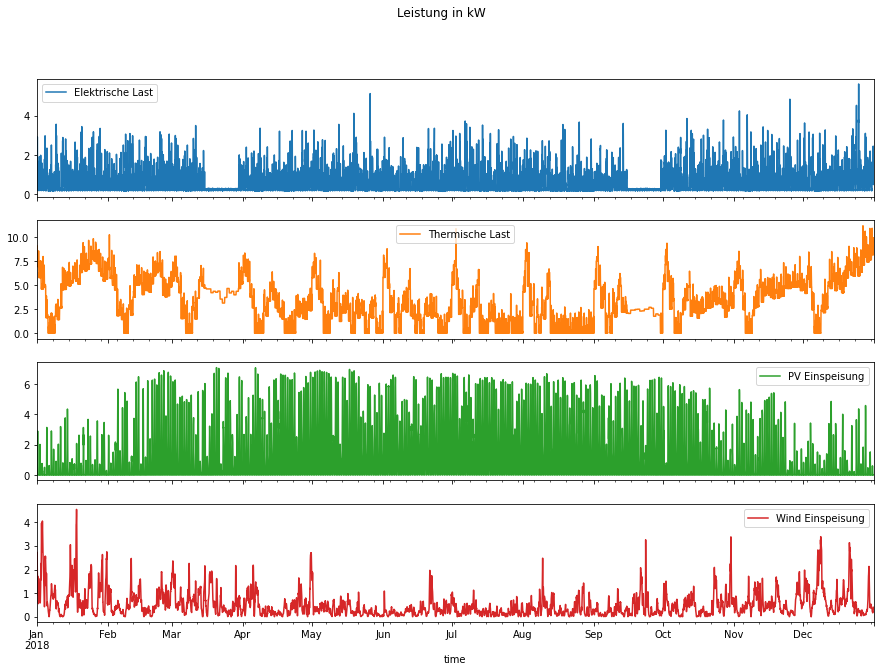

In [5]:
df_figure = pd.concat([electrical_load.sum_kwh, thermal_load.sum_kwh, pv_infeed.electricity,wind_infeed.electricity], axis = 1)
df_figure.columns = ['Elektrische Last', 'Thermische Last', 'PV Einspeisung', 'Wind Einspeisung']
df_figure.loc['01-01-18 00:00:00':'12-31-18 23:00:00'].plot(subplots = True, figsize=(15,10), title= 'Leistung in kW')

In [6]:

#PV-Anlage
pv = {"electrical_power": 9.0}

#Windanlage
wind = {"electrical_power": 5.0}

#Heizkessel
heating_boiler = {"thermal_power": 20.0,
                   "efficiency":0.99,# Effizienz als normierte Kennzahl
                   "gas_costs": 7} #Kosten in cent/kWh

#Leistungsbezug aus dem Netz
grid_import = {"electrical_power" : 15,
                "electricity_price": 30.0} #Preise in cent/kWh    

#Leistungsabgabe in das Netz
grid_export = {"electrical_power" : 0.7 * pv["electrical_power"], #Repräsentiert die 70% Kappungsgrenze bei kleinen PV-Anlagen
                "electricity_revenue": 12.30} #EEG-Erlöse in cent/kWh

#Netzwerk definieren
network = pypsa.Network()
network.set_snapshots(pv_infeed.index)
network.snapshot_weightings = pd.Series(data = 1/6, index = network.snapshots) #Jeder Zeitpunkt repräsentiert 10 Minuten also 1/6 Stunde.

#Stromknoten definieren
network.add("Bus", 
            name = "electricity")

#Wärmeknoten definieren
network.add("Bus", 
            name = "thermal")

#Elektrische Last
network.add("Load", 
            name ="electricity_load", 
            bus = "electricity", 
            p_set = electrical_load.sum_kwh)

#Thermische last
network.add("Load", 
            name ="thermal_load", 
            bus = "thermal", 
            p_set = thermal_load.sum_kwh)

#PV-Anlage
network.add("Generator", 
            name = "pv",
            bus = "electricity", 
            p_nom = pv["electrical_power"], 
            p_max_pu = pv_infeed.p_max_pu, 
            marginal_cost = 0)

#Windanlage
network.add("Generator", 
            name = "wind",
            bus = "electricity", 
            p_nom = wind["electrical_power"], 
            p_max_pu = wind_infeed.p_max_pu, 
            marginal_cost = 0)

#Heizkessel
network.add("Generator", 
            name = "boiler", 
            bus = "thermal", 
            p_nom = heating_boiler["thermal_power"], efficiency=heating_boiler["efficiency"], 
            marginal_cost = heating_boiler["gas_costs"]/heating_boiler["efficiency"])

#Netzbezug
network.add("Generator", 
            name = "grid_import",
            bus = "electricity", 
            p_nom = grid_import["electrical_power"], 
            marginal_cost = grid_import["electricity_price"])

#Netzeinspeisung
network.add("Generator", 
            name = "grid_export",
            bus = "electricity", 
            p_nom = grid_export["electrical_power"], 
            marginal_cost = -grid_export["electricity_revenue"], #Die Kosten müssen hier negativ sein, um Erlöse darzustellen
            sign = -1) #Das Vorzeichen -1 sorgt hier dafür, dass der Generator Leistung aufnimmt und nicht abgibt.



In [7]:
# Simulation der Basiskonfiguration für den kompletten Zeitraum:
network.lopf(solver_name = "cbc", pyomo = False) #Der Parameter pyomo = False hilft uns bei diesem Netzwerk RAM und Rechenzeit zu sparen.

INFO:pypsa.linopf:Prepare linear problem
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:85: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  ext_i = ext_i | n.generators.query('committable').index
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:185: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  if not (ext_i & com_i).empty:
INFO:pypsa.linopf:Total preparation time: 0.78s
INFO:pypsa.linopf:Solve linear problem using Cbc solver
INFO:pypsa.linopf:Optimization successful. Objective value: 1.49e+04


('ok', 'optimal')

In [8]:
#Auswertung der Kosten und Anteile
def cost_share_evaluation(network):
    '''
    This function evaluate the solved PyPSA network to get the costs, revenues and the share of the selfconsumption.
    
    Parameters
    ----------
    network:            PyPSA Network
                        The solved PyPSA network with all corresponding devices
    Returns
    -------
    results :           dict
                        The dictionary with all the results.
    '''
    
    grid_import = (network.generators_t.p['grid_import'] * network.snapshot_weightings).sum()
    grid_export = (network.generators_t.p['grid_export'] * network.snapshot_weightings).sum()
    self_consumed_pv = (network.generators_t.p['pv'] * network.snapshot_weightings).sum()- grid_export
    self_consumed_wind = (network.generators_t.p['wind']* network.snapshot_weightings).sum()
    self_consumption_ratio = (self_consumed_pv + self_consumed_wind)/(grid_import + self_consumed_pv + self_consumed_wind)
    
    electricity_cost = grid_import * network.generators.marginal_cost['grid_import']
    electricty_revenues = grid_export * network.generators.marginal_cost['grid_export']
    gas_costs = (network.generators_t.p['boiler']*network.snapshot_weightings).sum() * network.generators.marginal_cost['boiler']
    
    curtailment = ((network.generators_t.p_max_pu['pv']*network.generators.p_nom['pv'] - network.generators_t.p['pv'])*network.snapshot_weightings).sum()

    results = {"Eigenverbrauchsanteil": self_consumption_ratio,
              "Stromkosten": electricity_cost,
              "Gaskosten": gas_costs,
              "Stromerlöse": -electricty_revenues,
              "Gesamtkosten": electricity_cost + gas_costs + electricty_revenues,
              "Nicht nutzbare Energie": curtailment}
    results_energy = {'Abregelung': curtailment,
                      'Netzeinspeisung': grid_export,
                      'Eigenverbrauch': self_consumed_pv,
                      'Netzbezug': -grid_import}
                      
    return results, results_energy

In [9]:
results_base, results_energy_base  = cost_share_evaluation(network)

#Die Werte sollen auch als Text ausgegeben werden
print("Der Eigenverbrauchsanteil am Stromverbrauch in der Basiskonfiguration beträgt "
      + str(round(results_base["Eigenverbrauchsanteil"]*100,2))
      +"%. Dabei entstehen Stromkosten von "
      +str(round(results_base["Stromkosten"]/100,2))
      +"€, Gaskosten von "
      +str(round(results_base["Gaskosten"]/100,2))
      +"€ und EEG-Erlöse von "
      +str(round(results_base["Stromerlöse"]/100,2))
      +", wobei " +str(round(results_base["Nicht nutzbare Energie"]/100,1))+ "kWh PV-Strom abgeregelt werden muss."
      +" Die Gesamtkosten betragen "+ str(round(results_base["Gesamtkosten"]/100,2)) +"€."
     )

Der Eigenverbrauchsanteil am Stromverbrauch in der Basiskonfiguration beträgt 68.98%. Dabei entstehen Stromkosten von 78.6€, Gaskosten von 315.3€ und EEG-Erlöse von 244.84, wobei 0.0kWh PV-Strom abgeregelt werden muss. Die Gesamtkosten betragen 149.07€.


<AxesSubplot:xlabel='time'>

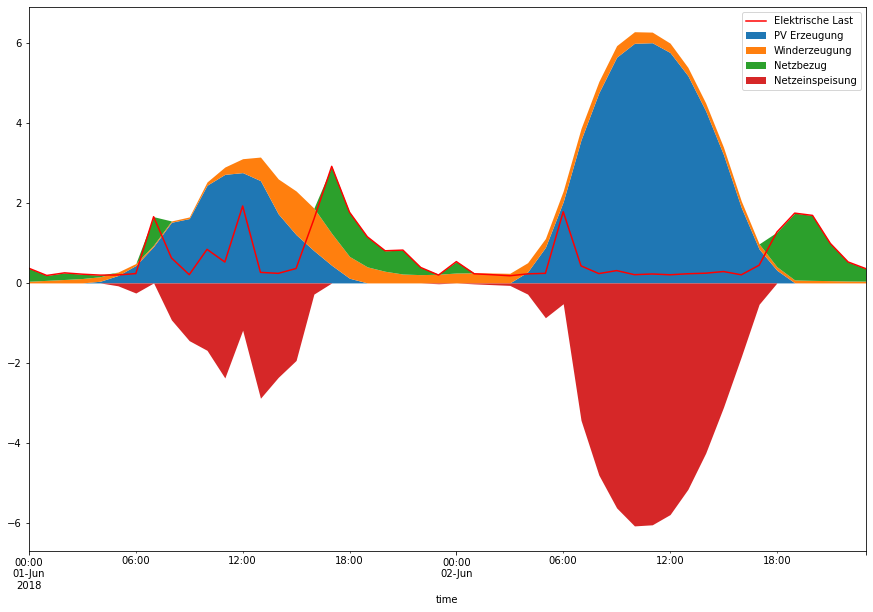

In [10]:
load_figure = network.loads_t.p_set['electricity_load']
load_figure.name = 'Elektrische Last'
ax = load_figure.loc['06-01-18 00:00:00':'06-02-18 23:00:00'].plot(legend = True, color = 'red')
df_figure_base = pd.concat([network.generators_t.p['pv'],network.generators_t.p['wind'], network.generators_t.p['grid_import'], -network.generators_t.p['grid_export']], axis = 1)
df_figure_base.columns = ['PV Erzeugung','Winderzeugung', 'Netzbezug', 'Netzeinspeisung']
df_figure_base.loc['06-01-18 00:00:00':'06-02-18 23:00:00'].plot(legend =True, subplots = False, figsize=(15,10), kind= 'area', linewidth=0, ax=ax)

## Erweiterung der Konfiguration

In [11]:

network_modified = pypsa.Network()
network_modified.set_snapshots(pv_infeed.index)
network_modified.snapshot_weightings = pd.Series(data = 1/6, index = network.snapshots) #Jeder Zeitpunkt repräsentiert 10 Minuten also 1/6 Stunde.

#Stromknoten definieren
network_modified.add("Bus", 
            name = "electricity")
#Wärmeknoten definieren
network_modified.add("Bus", 
            name = "thermal")
# Elektrische Last
network_modified.add("Load", 
            name ="electricity_load", 
            bus = "electricity", 
            p_set = electrical_load.sum_kwh)
# Thermische last
network_modified.add("Load", 
            name ="thermal_load", 
            bus = "thermal", 
            p_set = thermal_load.sum_kwh)
#PV-Anlage
network_modified.add("Generator", 
            name = "pv",
            bus = "electricity", 
            p_nom = pv["electrical_power"], 
            p_max_pu = pv_infeed.p_max_pu, 
            marginal_cost = 0)

#Windanlage
network_modified.add("Generator", 
            name = "wind",
            bus = "electricity", 
            p_nom = wind["electrical_power"], 
            p_max_pu = wind_infeed.p_max_pu, 
            marginal_cost = 0)

#Heizkessel
network_modified.add("Generator", 
            name = "boiler", 
            bus = "thermal", 
            p_nom = heating_boiler["thermal_power"], efficiency=heating_boiler["efficiency"], 
            marginal_cost = heating_boiler["gas_costs"]/heating_boiler["efficiency"])

#Netzbezug
network_modified.add("Generator", 
            name = "grid_import",
            bus = "electricity", 
            p_nom = grid_import["electrical_power"], 
            marginal_cost = grid_import["electricity_price"])
#Netzeinspeisung
network_modified.add("Generator", 
            name = "grid_export",
            bus = "electricity", 
            p_nom = grid_export["electrical_power"], 
            marginal_cost = -grid_export["electricity_revenue"], #Die Kosten müssen hier negativ sein, um Erlöse darzustellen
            sign = -1) #Das Vorzeichen -1 sorgt hier dafür, dass der Generator Leistung aufnimmt und nicht abgibt.


In [12]:
#Wärmepumpe
network_modified.add("Link", 
            name="heat_pump", 
            bus0="electricity", 
            bus1="thermal", 
            p_nom=2,
            efficiency = 2.8,
            capital_cost =  500        
           )

In [14]:
# Batteriespeicher
# Hilfsknoten
network_modified.add("Bus", 
            name = "storage_electricity")
#Einspeicherleistung vom Knoten "electricity" zum Knoten "storage_electricity"
network_modified.add("Link", 
            name = "electrical_storage_charge", 
            bus0 = "electricity", 
            bus1 = "storage_electricity", 
            p_nom = 2.4,
            efficiency = math.sqrt(0.85)
                    )
#Ausspeicherleistung vom Knoten "storage_electricity" zum Knoten "electricity"
network_modified.add("Link", 
            name = "electricity_storage_discharge", 
            bus0 = "storage_electricity", 
            bus1 = "electricity", 
            p_nom = 2.4,
            efficiency = math.sqrt(0.85)
                    )
#Speicher
network_modified.add("Store", 
            name = "electricity_storage", 
            bus = "storage_electricity", 
            e_nom = 8,         
            e_cyclic = True,
            capital_cost = 900        # Der Speicherfüllstand soll am Ende des Betrachtungszeitraumes wieder den Wert vom Anfang annehmen
            )

In [15]:
# Hilfsknoten
network_modified.add("Bus", 
            name = "storage_thermal")
#Einspeicherleistung vom Knoten "thermal" zum Knoten "storage_thermal"
network_modified.add("Link", 
            name = "hot_water_storage_charge", 
            bus0 = "thermal", 
            bus1 = "storage_thermal", 
            p_nom = 12)
#Ausspeicherleistung vom Knoten "storage_thermal" zum Knoten "thermal"
network_modified.add("Link", 
            name = "hot_water_storage_discharge", 
            bus0 = "storage_thermal", 
            bus1 = "thermal", 
            p_nom = 12)
#Speicher
network_modified.add("Store", 
            name = "hot_water_storage", 
            bus = "storage_thermal", 
            e_nom = 7, 
            e_cyclic = True,
            capital_cost=100        ) # Der Speicherfüllstand soll am Ende des Betrachtungszeitraumes wieder den Wert vom Anfang annehmen
                     

##Simulation der erweiterten Konfiguration

In [16]:
# Simulation für den kompletten Zeitraum:
network_modified.lopf(solver_name = "cbc", pyomo = False) #Der Parameter pyomo = False hilft uns bei diesem Netzwerk RAM und Rechenzeit zu sparen.

INFO:pypsa.linopf:Prepare linear problem
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:85: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  ext_i = ext_i | n.generators.query('committable').index
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:185: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  if not (ext_i & com_i).empty:
INFO:pypsa.linopf:Total preparation time: 1.31s
INFO:pypsa.linopf:Solve linear problem using Cbc solver
INFO:pypsa.linopf:Optimization successful. Objective value: 3.62e+03


('ok', 'optimal')

In [17]:
# Ausführung der Auswertungsfunktion
results_with_modification, results_energy_with_modification = cost_share_evaluation(network_modified)
print("Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt "
      + str(round(results_with_modification["Eigenverbrauchsanteil"]*100,2))
      +"%.\n Dabei entstehen Stromkosten von "
      +str(round(results_with_modification["Stromkosten"]/100,2))
      +"€, Gaskosten von "
      +str(round(results_with_modification["Gaskosten"]/100,2))
      +"€ und EEG-Erlöse von "
      +str(round(results_with_modification["Stromerlöse"]/100,2))
      +", wobei " +str(round(results_with_modification["Nicht nutzbare Energie"]/100,1))
      + "kWh PV-Strom abgeregelt werden müssen.\n"
      +" Die Gesamtkosten betragen "+ str(round(results_with_modification["Gesamtkosten"]/100,2)) 
      +"€.\n"
      +"Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um "
      +str(round((results_with_modification["Eigenverbrauchsanteil"]- results_base["Eigenverbrauchsanteil"])*100,2))
      +" Prozentpunkte und eine Verringerung der Kosten um "
      +str(round((results_base["Gesamtkosten"]-results_with_modification["Gesamtkosten"])/100,2))
      +"€."
     )

Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt 99.6%.
 Dabei entstehen Stromkosten von 2.31€, Gaskosten von 117.93€ und EEG-Erlöse von 84.08, wobei 0.0kWh PV-Strom abgeregelt werden müssen.
 Die Gesamtkosten betragen 36.17€.
Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um 30.62 Prozentpunkte und eine Verringerung der Kosten um 112.9€.


In [ ]:
##Visualisierung des Vergleichs

In [ ]:
total_load = pd.concat([network_modified.loads_t.p_set['electricity_load'], network_modified.links_t.p0['heat_pump']], axis = 1)
total_load.columns = ['Elektrische Last', 'Wärmepumpe']
ax = total_load.loc['06-01-18 00:00:00':'06-02-18 23:00:00'].plot(color = ['red', 'black'], legend = True, stacked = False)
df_figure_with_modification = pd.concat([network_modified.generators_t.p['pv'],network.generators_t.p['wind'], network_modified.generators_t.p['grid_import'], -network_modified.generators_t.p['grid_export']], axis = 1)
df_figure_with_modification.columns = ['PV Erzeugung', 'Winderzeugung,''Netzbezug', 'Netzeinspeisung']
df_figure_with_modification.loc['06-01-18 00:00:00':'06-02-18 23:00:00'].plot(subplots = False, figsize=(15,10), kind= 'area', linewidth=0, ax = ax)

In [ ]:
energy_figure = pd.DataFrame([results_energy_base, results_energy_with_modification], index = ['Basis', 'Mit Modifikation'])

In [ ]:
energy_figure.plot(kind='bar', stacked = True, figsize=(14,7), title = 'Elektrizitätsbilanz in kWh')